## 2570 Project 4

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st

%matplotlib inline

### Q1

In [2]:
'''
Returns the theoretical price and delta of a digital option
'''
def digit_theo(K, St, r, sig, T, t):
    d1 = (np.log(St/K) + (r + sig**2/2)*(T-t))/(sig*np.sqrt(T-t))
    d2 = d1 - sig*np.sqrt(T-t)
    ## price
    c_digital = np.exp(-r*(T-t))*st.norm.cdf(d2)
    ## delta
    delta_digital_theo = np.exp(-r*(T-t))*st.norm.pdf(d2)/(sig*St*np.sqrt(T-t))
    return (c_digital, delta_digital_theo)

'''
forward difference method for estimating delta of digital option
'''
def digit_fwd_diff(K, St, r, sig, T, t, h, n):
    ## get n normal random variables as paths
    W = st.norm.rvs(size = n)
    ## calculate difference in payoff
    diff_payoff = (((St+h)*np.exp((r-1/2*sig**2)*(T-t)+sig*np.sqrt(T-t)*W) > K).astype(int) - 
                   ((St)*np.exp((r-1/2*sig**2)*(T-t)+sig*np.sqrt(T-t)*W) > K).astype(int)) 
    ## calculate difference in price
    diff_val = np.exp(-r*(T-t))*diff_payoff/(2*h)
    ## return the expected value (mean) as estimation
    return np.mean(diff_val)

def mse(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)

In [3]:
## Provided parameters
K = 110
St = 100
r = 0.02
sig = 0.25
T = 0.25
t = 0
n = 5000

In [4]:
## get true delta
y_true = digit_theo(K, St, r, sig, T, t)[1]
## h's we will be plotting over
h = np.linspace(0.01, 50, 1000)
## get mean square error for each h
fwd_errors = [mse(y_true, digit_fwd_diff(K, St, r, sig, T, t, hi, n)) for hi in h]

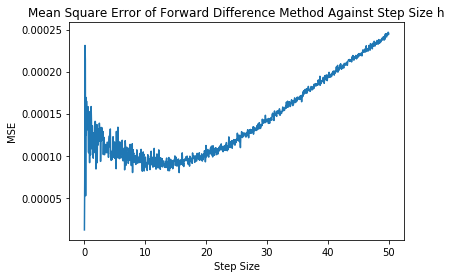

In [5]:
## plot errors vs. h
plt.plot(h, fwd_errors)
plt.title('Mean Square Error of Forward Difference Method Against Step Size h')
plt.ylabel('MSE')
plt.xlabel('Step Size');

By eyeball estimation, the optimal h is about 13.

### Q2

In [6]:
'''
simulate a GBM path for the Asian Options with a given RNG up to m weeks, repeat n times
'''
def sim_path(K, S0, r, sig, m, n, W):
    dt = 1/52
    ## simlate weekly returns
    weekly_returns = np.exp((r - 1/2*sig**2)*dt + sig*np.sqrt(dt)*W)
    ## simulate path
    Sti = S0 * np.cumprod(weekly_returns, axis = 1)
    return Sti

'''
Calculate the vegas of an Asian Option using pathwise derivative
'''
def asian_pathwise(K, S0, r, sig, m, n, paths):
    T = m/52
    ti = np.array([i/52 for i in range(1, m+1)])
    ti = np.tile(ti, (n, 1))
    indic =  (np.mean(paths, axis = 1) > K).astype(int)
    dSti = (np.log(paths/S0) - (r + 1/2*sig**2)*ti)*paths/sig
    return np.exp(-r*T)*np.sum(dSti, axis = 1)*indic/m

'''
Calculate the vegas of an Asian Option using likelihood ratio
'''
def asian_lr(K, S0, r, sig, m, n, paths, Z):
    T = m/52
    dt = 1/52
    indic =  (np.mean(paths, axis = 1) > K).astype(int)
    payoff = np.exp(-r*T)*(np.mean(paths, axis = 1) - K)*indic
    return payoff*np.sum((Z**2-1)/sig - Z*np.sqrt(dt), axis = 1)

In [7]:
## Provided parameters
S0 = 100
K = 100
sig = 0.3
r = 0.05

n = 10000

In [8]:
## simulate 
## malloc
var_pw = np.zeros(256)
mean_pw = np.zeros(256)
var_lr = np.zeros(256)
mean_lr = np.zeros(256)

## go through m's
for m in np.arange(1, 257):
    ## generate n normal paths of length m
    norms = np.random.normal(size = (n, m))
    ## generate n GBMs with length m
    paths = sim_path(K, S0, r, sig, m, n, norms)
    ## Pathwise derivative
    pathwise_sim = asian_pathwise(K, S0, r, sig, m, n, paths)
    mean_pw[m-1] = np.mean(pathwise_sim)
    var_pw[m-1] = np.log(np.var(pathwise_sim))/np.log(10)
    ## Likelihood ratio
    lr_sim = asian_lr(K, S0, r, sig, m, n, paths, norms)
    mean_lr[m-1] = np.mean(lr_sim)
    var_lr[m-1] = np.log(np.var(lr_sim))/np.log(10)

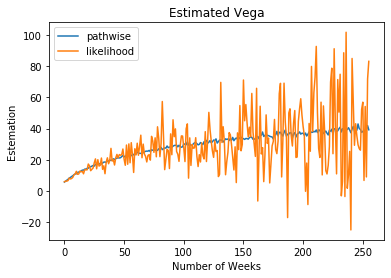

In [9]:
plt.plot(mean_pw, label = 'pathwise')
plt.plot(mean_lr, label = 'likelihood')
plt.title('Estimated Vega')
plt.legend()
plt.ylabel('Estemation')
plt.xlabel('Number of Weeks');

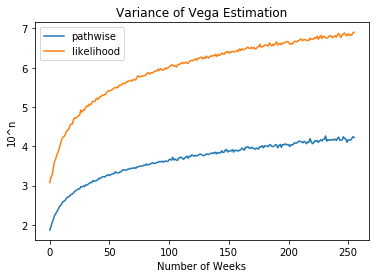

In [10]:
plt.plot(var_pw, label = 'pathwise')
plt.plot(var_lr, label = 'likelihood')
plt.title('Variance of Vega Estimation')
plt.legend()
plt.ylabel('10^n')
plt.xlabel('Number of Weeks');

### Q3

In [13]:
xy = pd.read_csv('data/XY.csv')[['X', 'Y']]

,X,Y
0,-0.711949,0.905877
1,0.525184,-0.530109
2,-0.931636,-0.463232
3,0.969728,1.487889
4,-0.929060,-1.611730
...,...,...
195,1.355433,-0.766347
196,1.618233,0.842051
197,-0.202812,-1.028919
198,-1.594562,-0.736014
